We want to find out A of wave equation


$$\frac{1}{v^2} \frac{\delta^2 y}{\delta t^2}- \frac{\delta ^2}{\delta x^2}= 0$$

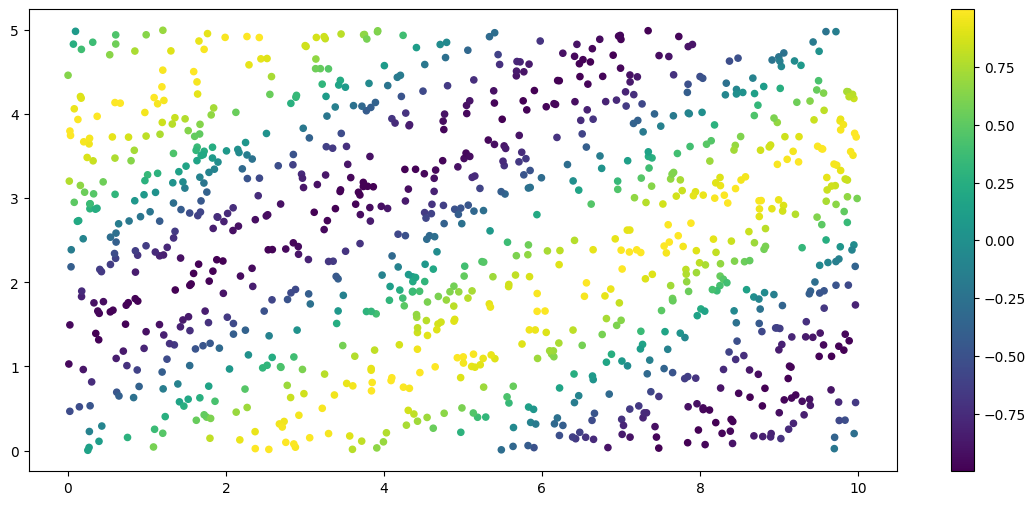

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from math import exp
import functools

import torch 
from torch import nn, optim
from torch.nn import functional as F

from sklearn.model_selection import train_test_split


# def wave_function(x, t, A=1, v=2):
#     """
#     Compute the wave function y(x, t) = A * sin(x - vt).
    
#     Parameters:
#     - x: Array of x values.
#     - t: Time parameter.
#     - A: Amplitude (default is 1).
#     - v: Velocity (default is 1).
    
#     Returns:
#     - Array of y values.
#     """
#     matrix = np.zeros(len(t))
#     #det her ikke en matrix
#     for i in range(len(t)):

#         matrix[i] = [A * np.sin(x - v * t[i])]

#     return matrix #A * np.sin(x - v * t)

# Define the domain
L = 10  # Length of the spatial domain
T = 5   # Time duration
num_samples = 1000  # Number of samples

# Generate random sample points
x_samples = np.random.uniform(0, L, num_samples)
t_samples = np.random.uniform(0, T, num_samples)

# Compute the wave function values (assuming a known solution)
# For demonstration, let's use a simple sinusoidal wave solution
# u(x, t) = A * sin(k * x - omega * t)
A = 1        # Amplitude
k = 2 * np.pi / L   # Wave number
omega = 2 * np.pi / T  # Angular frequency

u_samples = A * np.sin(k * x_samples - omega * t_samples)

# Feature-set and target-set
features = np.column_stack((x_samples, t_samples))
targets = u_samples

plt.figure(figsize=(14, 6), dpi=100)
plt.scatter(features[:, 0], features[:, 1], c=targets, s=20, cmap='viridis')
plt.colorbar()

    
# # Generate x values
# x_values = np.linspace(0, 10 * np.pi, 1000)

# # Choose a time parameter (you can change this value)
# t_parameter = np.linspace(0, 10 * np.pi, 1000)
# x_value = 10

# # Compute y values for the chosen time parameter
# y_values = wave_function(x_values, t_parameter)

# print(y_values)
# # Plot the wave function
# plt.plot(t_parameter, y_values)
# plt.title('Wave Function Simulation')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()
# plt.show()

# print(np.shape(y_values))


In [11]:
import sys

print(sys.version)

3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]


In [12]:

def u(x,t,A,v): return A*np.sin(x - v*t)

def u_diff_diff_tt(x,t,v,A): return A*(v**2)*np.sin(-x - v*t)

def u_diff_diff_xx(x,t,v,A): return A*np.sin(-x - v*t)



In [13]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, n_layers=2):
        
        super(Net, self).__init__()
        
        # model discovery parameters
        #self.A = nn.Parameter(data=torch.tensor(0.), requires_grad=True) # rate of temp change. Init=0.
        
        activation = nn.Softplus # nn.LeakyReLU, nn.Tanh, nn.ReLU, nn.ELU

        self.input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            activation()
        )
        
        self.network = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                activation()
            ) for i in range(n_layers)]
        )

        self.output = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.input(x)
        x = self.network(x)
        x = self.output(x)
        return x


In [14]:
def gradient(outputs, inputs, order=1):
    """
    Computes the partial derivative of 
    an output with respect to an input.
    Given an order, we compute the gradient multiple times.
    """
    grads = []
    for i in range(order):
        grads.append(torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0])
        outputs = grads[-1]
    
    return outputs, grads



In [15]:
A, v = 2, 4

def u(x,t): return A*np.sin(x - v*t)

def u_diff_diff_tt(x,t): return A*(v**2)*np.sin(-x - v*t)

def u_diff_diff_xx(x,t): return A*np.sin(-x - v*t)

def initial_condition_2(model: nn.Module, x):
    # v = 0 for t = 0
    pred_pressure0 = model(x,torch.tensor([0.0]))
    pred_velocity0 = gradient(pred_pressure0,t)

    return torch.mean(pred_velocity0)**2

def initial_condition_1(model: nn.Module, x):
    # Gaussian source
    x0 = 0 # positions of the source
    sigma0 = 1 # width of the frequency 

    pressure0 = -torch.exp((x - x0)/sigma0)**2
    pred_pressure0 = model(x,torch.tensor([0.0]))

    return torch.mean(pressure0 - pred_pressure0)**2

def boundary_condition(model: nn.Module, t):
    # pressure gradient is infinite at perfect boundary
    x = None # define the boundary
    pred_pressure0 = model(x,t)
    pred_velocity0 = gradient(pred_pressure0,t)

    return torch.mean(1/pred_pressure0)**2


def pde(x, t, v):
    return 1/(v**2) *u_diff_diff_tt(x,t) - u_diff_diff_xx(x,t)

def pde_loss(model: nn.Module, coll_points):
    """
    1/v^2 * u_tt - u_xx = 0
    """
 
    L = 10  # Length of the spatial domain
    T = 5   # Time duration
    num_samples = 1000  # Number of samples

    # Generate random sample points
    x_s = np.random.uniform(0.0, L, coll_points)
    t_s = np.random.uniform(0.0, T, coll_points)

    x_s_ = torch.tensor(x_s, dtype = torch.float).requires_grad_(True)
    t_s_ = torch.tensor(t_s, dtype = torch.float).requires_grad_(True)

    input1 = torch.column_stack((x_s_, t_s_))

    input1_ = input1.reshape(-1, 2).requires_grad_(True)

    Wave = model(input1_)

#compute the gradients
    
    u_tt,_ = gradient(Wave, x_s_, order=2)
    u_xx,_ = gradient(Wave, t_s_, order=2)

#compute the loss
    model_pde = (1/(v**2) * u_tt - u_xx)
    #true_pde = pde(x, t, v)

    loss = torch.mean((model_pde - 0)**2)

    return loss




In [16]:
print(np.shape(features))

(1000, 2)


In [17]:
from softadapt import LossWeightedSoftAdapt



features_ = torch.tensor(features).float().reshape(-1, 2).requires_grad_(True)
targets_ = torch.tensor(targets).float().reshape(-1, 1).requires_grad_(True)

print(features_.shape)
print(targets_.shape)


torch.Size([1000, 2])
torch.Size([1000, 1])


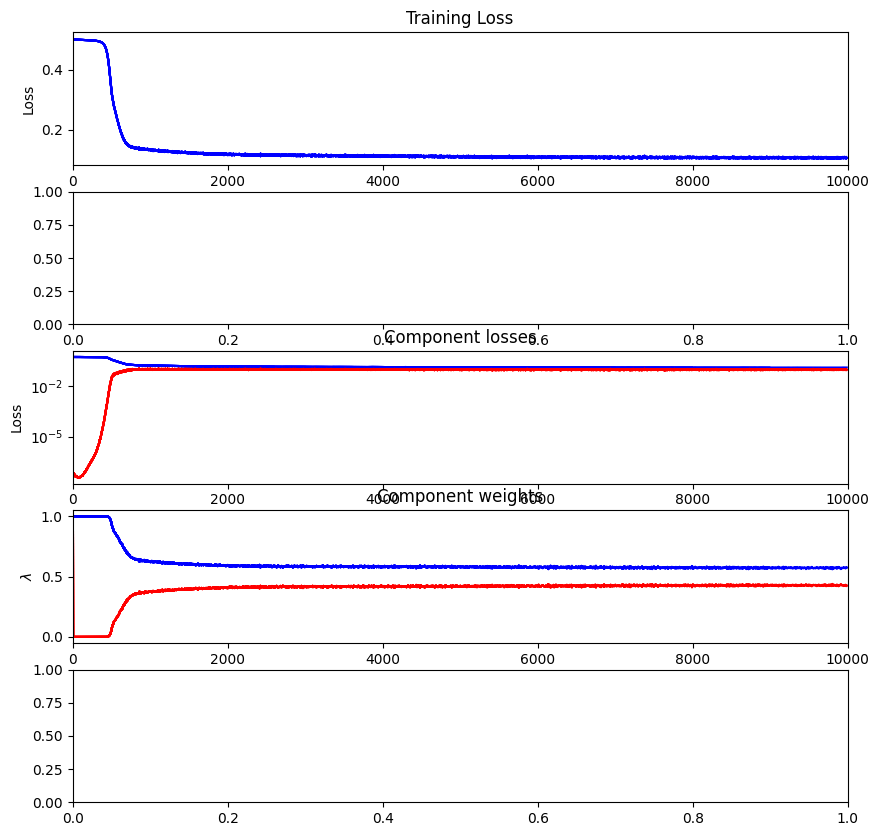

In [18]:
# defining model
pinn = Net(input_dim=2, output_dim=1, hidden_dim=32, n_layers=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(pinn.parameters(), lr=1e-4, weight_decay=1e-5)


### SoftAdapt parameters
# Change 1: Create a SoftAdapt object (with your desired variant)
softadapt_object = LossWeightedSoftAdapt(beta=0.1)

# Change 2: Define how often SoftAdapt calculate weights for the loss components
epochs_to_make_updates = 5

# Change 3: Initialize lists to keep track of loss values over the epochs we defined above
values_of_component_1 = []
values_of_component_2 = []

# Initializing adaptive weights to all ones.
adapt_weights = torch.tensor([1,1])




### training loop
epochs = 10000

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 10), nrows=5)

losses = np.zeros(epochs)
losses_data = np.zeros(epochs)
losses_physics = np.zeros(epochs)


lambda_data = np.zeros(epochs)
lambda_physics = np.zeros(epochs)


epochs_x = np.arange(epochs)

verbose = True
pinn.train()



for epoch in range(epochs):
    optimizer.zero_grad()
    wave_pred = pinn(features_) #features skal have to coloumns

    # regular data driven loss
    loss_data = criterion(wave_pred, targets_)

    # ODE physics loss
    loss_physics = pde_loss(pinn, coll_points=1000)



    values_of_component_1.append(loss_data)
    values_of_component_2.append(loss_physics)
    

    
    # Change 4: Make sure `epochs_to_make_change` have passed before calling SoftAdapt.
    if epoch % epochs_to_make_updates == 0 and epoch != 0:
        adapt_weights = softadapt_object.get_component_weights(torch.tensor(values_of_component_1), 
                                                                torch.tensor(values_of_component_2),
                                                                verbose=False,
                                                                )
                                
        # Resetting the lists to start fresh (this part is optional)
        values_of_component_1 = []
        values_of_component_2 = []
    
    # Change 5: Update the loss function with the linear combination of all components.
    loss = adapt_weights[0] * loss_data + adapt_weights[1]*loss_physics
    

    loss.backward()                 # Backward pass: Compute gradient of the loss with respect to model parameters
    optimizer.step()                # Update weights
    
    # logging
    losses_data[epoch] = loss_data.item()
    losses_physics[epoch] = loss_physics.item()
    losses[epoch] = loss.item()


    lambda_data[epoch] = adapt_weights[0].detach().numpy()
    lambda_physics[epoch] = adapt_weights[1].detach().numpy()
    
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    # print(f'lambda_data: {lambda_data[epoch]}, lambda_physics: {lambda_physics[epoch]}')
    # print(f'loss_data: {loss_data.item()}, loss_physics: {loss_physics.item()}')
    # print(f'loss_data/loss_physics: {loss_data.item()/loss_physics.item()}')


    
    if epoch % 999 == 0 and epoch != 0 and verbose:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

        # Plotting the loss
        ax[0].plot(epochs_x[:epoch], losses[:epoch], 'b')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Training Loss')
        ax[0].set_xlim(0, epochs)

        # ## Plotting the function
        # full_u_pred = pinn(torch.tensor(times).float().reshape(-1, 1)).detach().numpy()
        # ax[1].plot(times, temps, 'black', label='Ground Truth')
        # ax[1].scatter(t, T,c='blue', label='Training observations')
        # ax[1].plot(times, full_u_pred, 'red', label='Prediction')
        # ax[1].set_xlabel('time t')
        # ax[1].set_ylabel('T(t)')
        # ax[1].set_title(f'Prediction for epoch {epoch+1}/{epochs}')
        # ax[1].set_ylim(0, 100)
        # plt.tight_layout()

        ### Plotting the loss components
        ax[2].plot(epochs_x[:epoch], losses_data[:epoch], 'b', label='Data Loss')
        ax[2].plot(epochs_x[:epoch], losses_physics[:epoch], 'r', label='Physics Loss')
        
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('Loss')
        ax[2].set_title('Component losses')
        ax[2].set_xlim(0, epochs)
        ax[2].set_yscale("log")

        ### Plotting the weights
        ax[3].plot(epochs_x[:epoch], lambda_data[:epoch], c='b', label='Data weight')
        ax[3].plot(epochs_x[:epoch], lambda_physics[:epoch], c='r', label='Physics weight')
        #ax[3].plot(epochs_x[:epoch], lambda_ic[:epoch], c='g', label='IC weight')
        ax[3].set_xlabel('Epochs')
        ax[3].set_ylabel('$\lambda$')
        ax[3].set_title('Component weights')
        ax[3].set_xlim(0, epochs)


        #ax[4].plot(epochs_x[:epoch],t_diffs[:epoch], label = "The diff")
        #ax[4].set_title('Mean of T_diff(t) over 1000 points')

        display.clear_output(wait=True)
        display.display(fig)
        
        # Pause a bit so that the plot updates
        plt.pause(0.1)

